Saving data.csv to data (1).csv
Testing logistic regression assumptions...

Testing for multicollinearity...


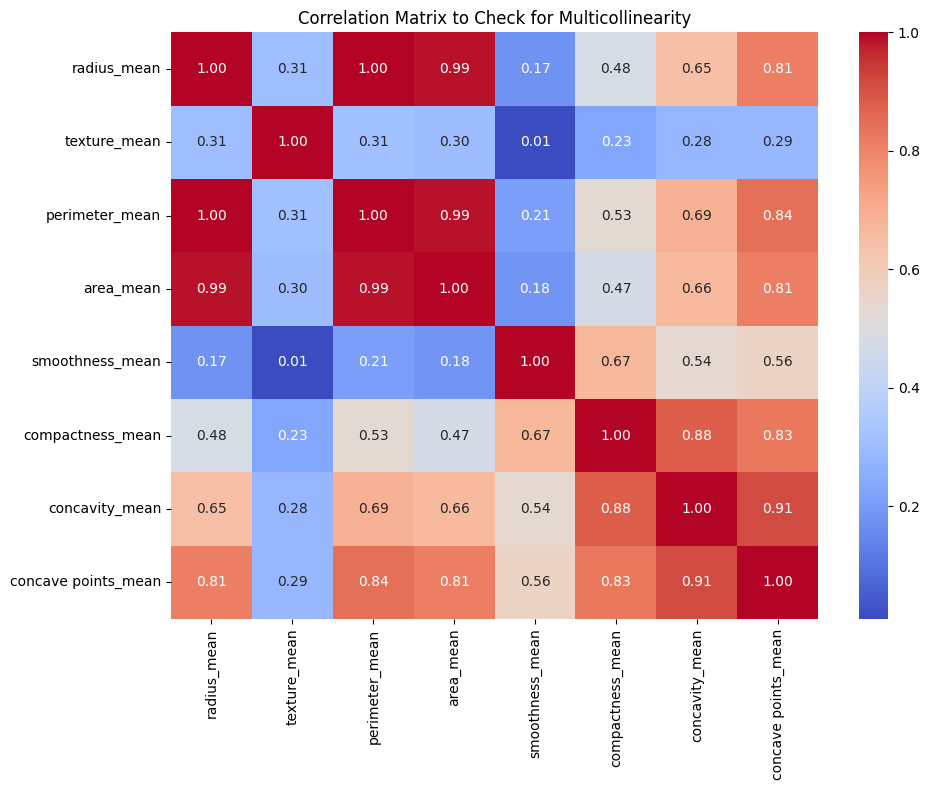

              Variable           VIF
0          radius_mean  25741.355696
1         texture_mean     23.048942
2       perimeter_mean  28268.965640
3            area_mean    139.491723
4      smoothness_mean     73.633708
5     compactness_mean     67.128056
6       concavity_mean     21.213922
7  concave points_mean     40.956183
⚠️ High multicollinearity detected (VIF > 10)

Testing for linearity of log-odds...


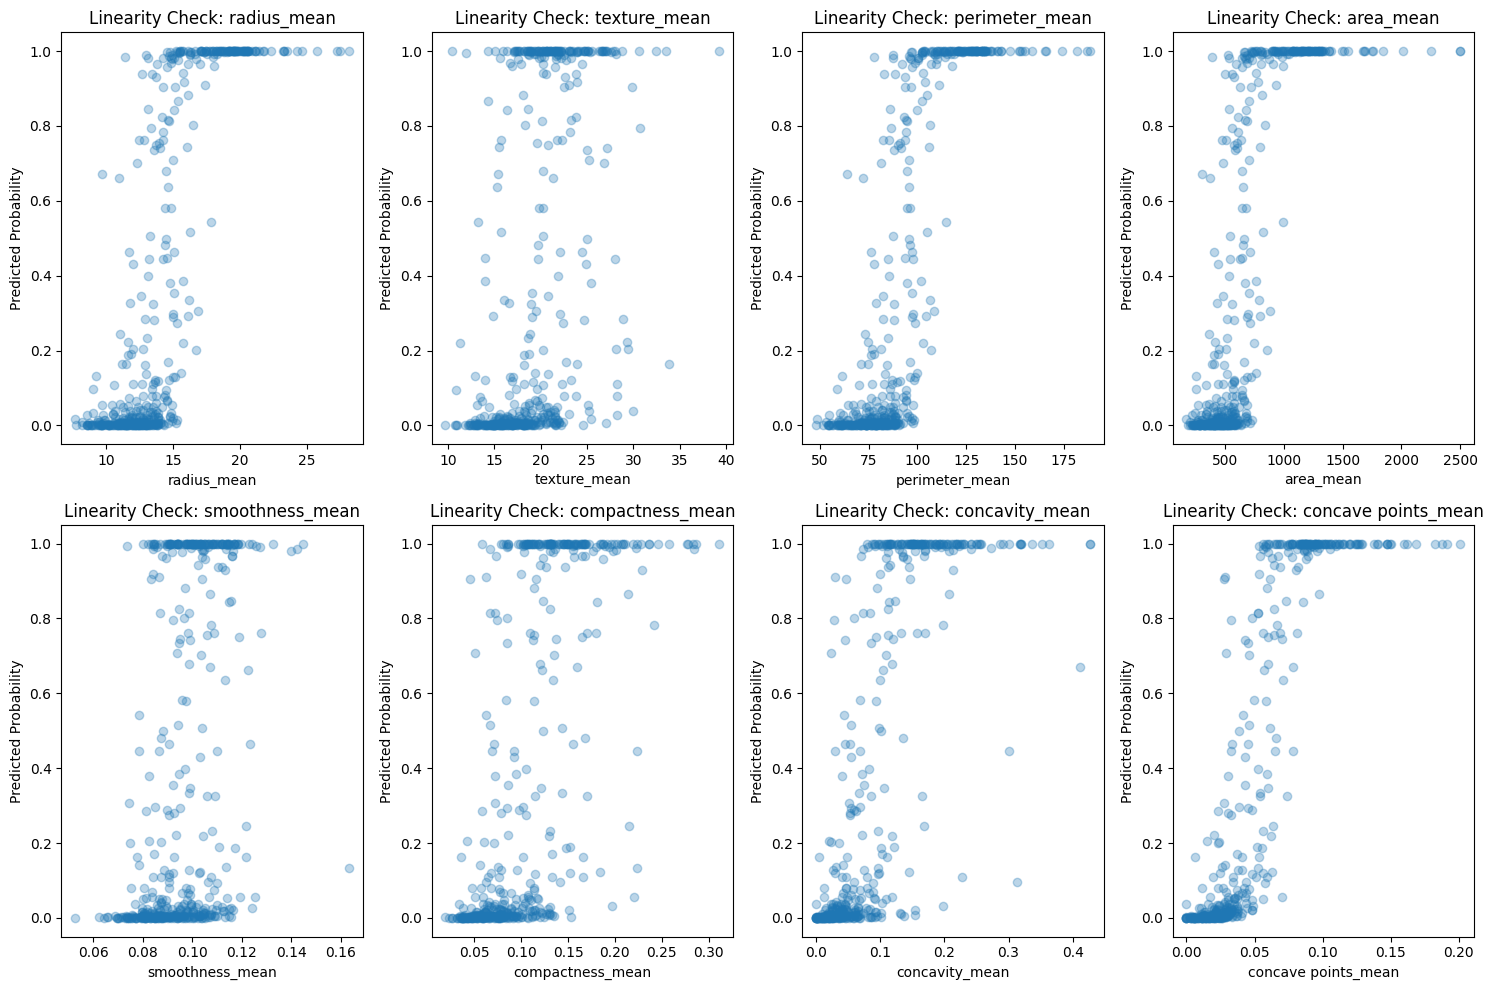

⚠️ Non-linear relationship detected for radius_mean
⚠️ Non-linear relationship detected for texture_mean
⚠️ Non-linear relationship detected for perimeter_mean
⚠️ Non-linear relationship detected for area_mean
⚠️ Non-linear relationship detected for concavity_mean

Note: Independence of observations should be verified based on study design

Checking for influential outliers...
⚠️ Could not compute influence measures

⚠️ Logistic regression assumptions are not met. Using Random Forest instead.

---------- Results for Lay Audience ----------
Model accuracy: 94.7%

Top 3 predictors of malignancy:
- concave points_mean: accounts for 23.0% of the predictive power
- perimeter_mean: accounts for 20.8% of the predictive power
- area_mean: accounts for 14.8% of the predictive power

Creating visualizations for lay audience...


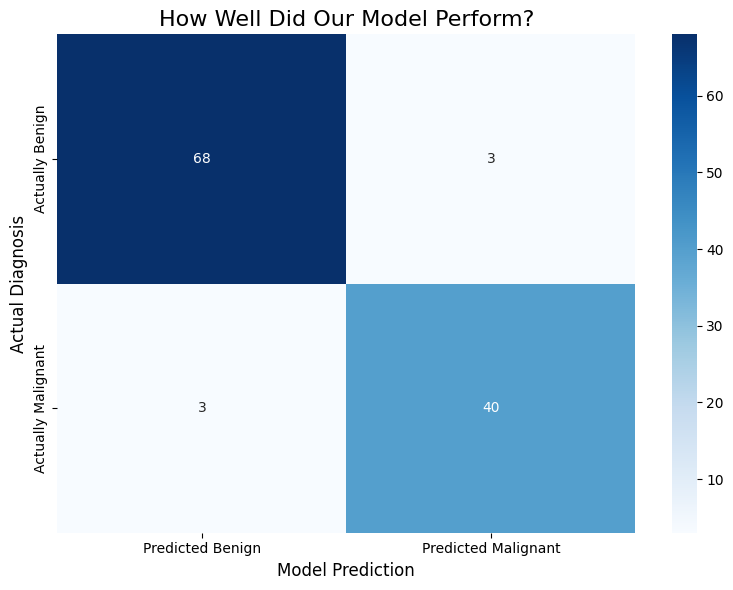

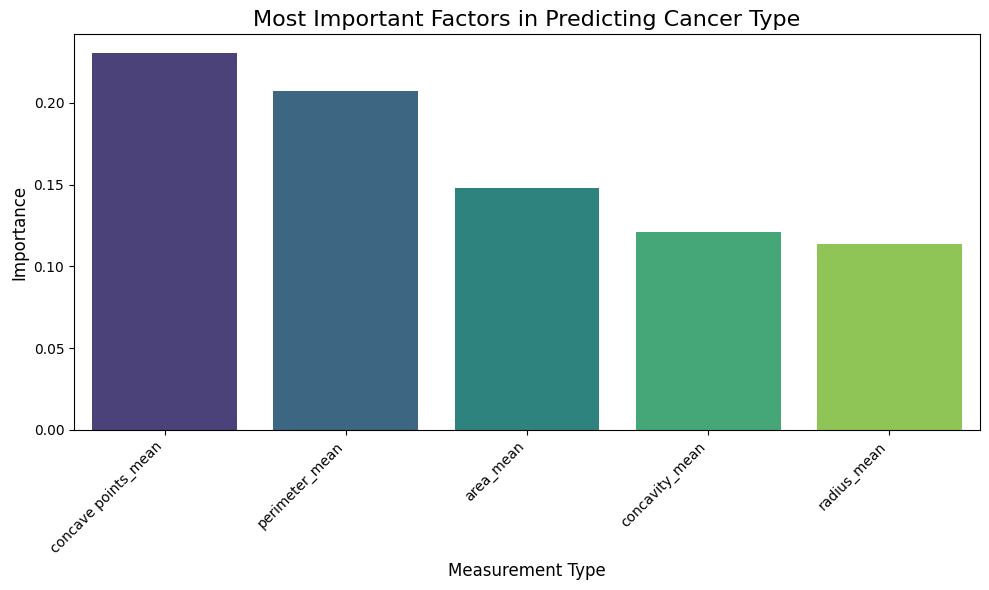

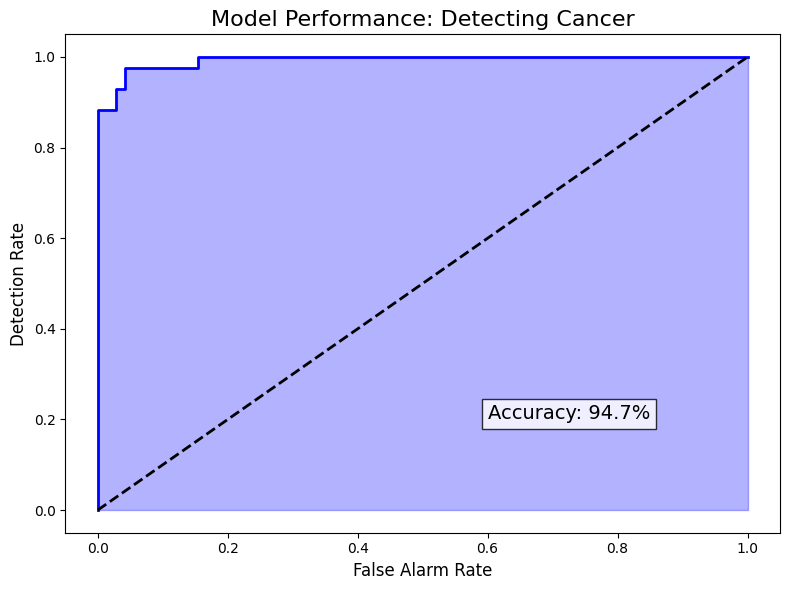

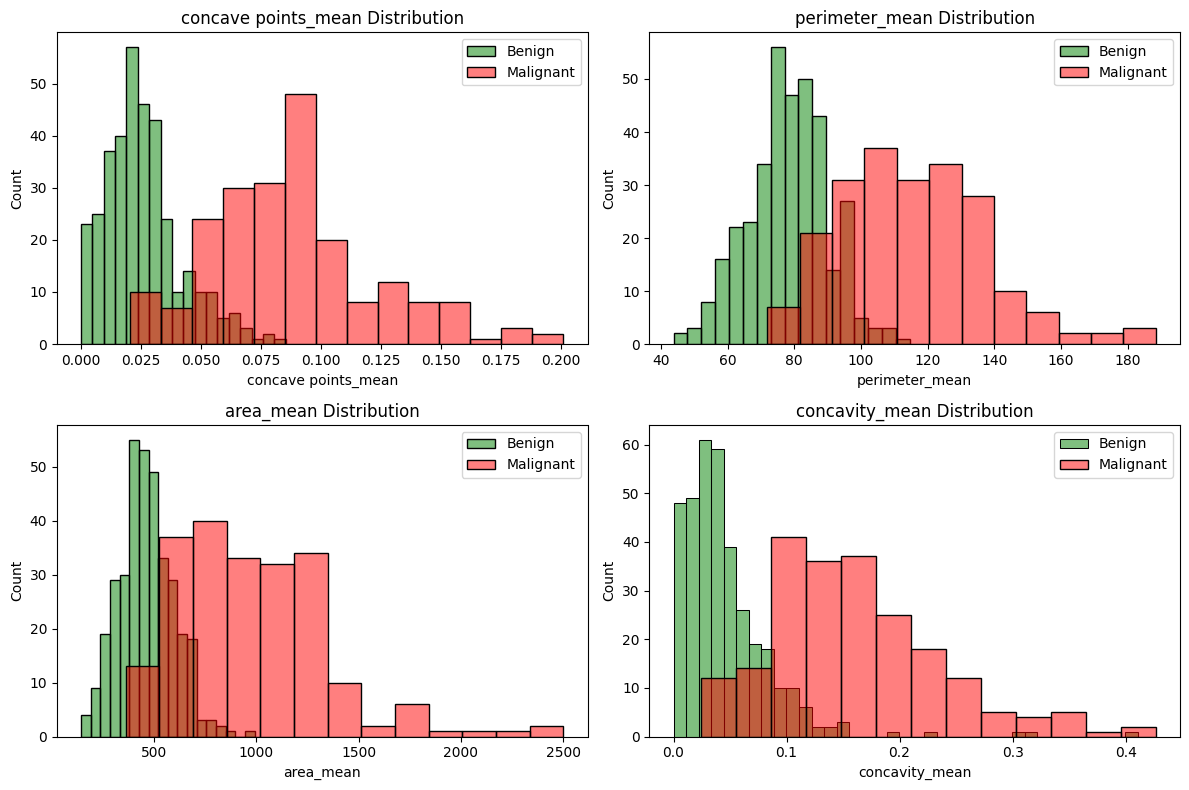

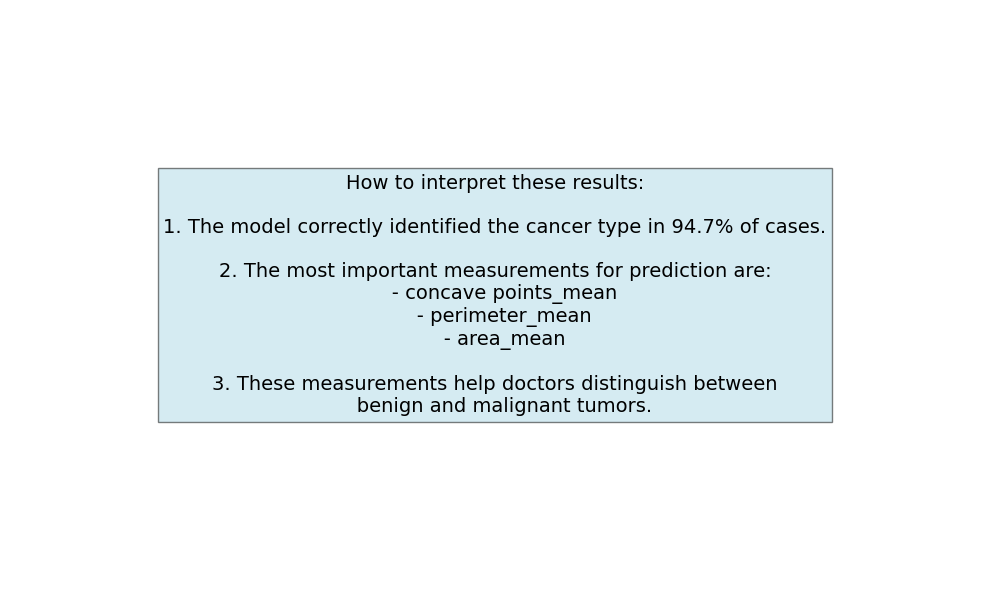

In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the data
# For Google Colab environment
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the CSV file
import io
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

# Prepare the data
X = df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
        'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']]
y = df['diagnosis'].map({'M': 1, 'B': 0})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to test assumptions for logistic regression
def test_logistic_regression_assumptions(X, y):
    assumptions_met = True

    # Add constant for statsmodels
    X_with_const = sm.add_constant(X)

    # 1. Test for multicollinearity
    print("Testing for multicollinearity...")
    correlation_matrix = X.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix to Check for Multicollinearity')
    plt.tight_layout()
    plt.show()

    # Check VIF values
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

    if (vif_data["VIF"] > 10).any():
        print("⚠️ High multicollinearity detected (VIF > 10)")
        assumptions_met = False
    else:
        print("✓ Multicollinearity test passed")

    # 2. Test for linearity of log-odds
    print("\nTesting for linearity of log-odds...")
    model = sm.Logit(y, X_with_const)
    try:
        result = model.fit(disp=0)

        # Plot predicted probabilities vs. features
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(X.columns):
            plt.subplot(2, 4, i+1)
            plt.scatter(X[col], result.predict(X_with_const), alpha=0.3)
            plt.xlabel(col)
            plt.ylabel('Predicted Probability')
            plt.title(f'Linearity Check: {col}')
        plt.tight_layout()
        plt.show()

        # Check if any feature has a non-linear relationship
        # (This is a simplified check, normally would use Box-Tidwell test)
        for col in X.columns:
            X_temp = X_with_const.copy()
            X_temp[f"{col}_squared"] = X_temp[col] ** 2
            model_temp = sm.Logit(y, X_temp)
            result_temp = model_temp.fit(disp=0)
            if result_temp.pvalues[f"{col}_squared"] < 0.05:
                print(f"⚠️ Non-linear relationship detected for {col}")
                assumptions_met = False

        if assumptions_met:
            print("✓ Linearity of log-odds assumption seems reasonable")

    except:
        print("⚠️ Model convergence issues - may indicate problems with assumptions")
        assumptions_met = False

    # 3. Test for independence of observations
    print("\nNote: Independence of observations should be verified based on study design")

    # 4. Check for influential outliers
    print("\nChecking for influential outliers...")
    try:
        from statsmodels.stats.outliers_influence import OLSInfluence
        influence = OLSInfluence(result)
        leverage = influence.hat_matrix_diag

        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(leverage)), leverage, alpha=0.5)
        plt.axhline(2 * (X.shape[1] + 1) / X.shape[0], color='red', linestyle='--')
        plt.title('Leverage Values')
        plt.xlabel('Observation Index')
        plt.ylabel('Leverage')
        plt.show()

        if (leverage > 2 * (X.shape[1] + 1) / X.shape[0]).sum() > 0.05 * X.shape[0]:
            print("⚠️ Many influential outliers detected")
            assumptions_met = False
        else:
            print("✓ No concerning pattern of influential outliers")
    except:
        print("⚠️ Could not compute influence measures")
        assumptions_met = False

    return assumptions_met

# Test the assumptions
print("Testing logistic regression assumptions...\n")
assumptions_met = test_logistic_regression_assumptions(X_train, y_train)

# Choose the appropriate model based on assumptions
if assumptions_met:
    print("\n✓ Logistic regression assumptions are reasonably met. Proceeding with logistic regression.")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Get statistical output
    log_reg_summary = sm.Logit(y_train, sm.add_constant(X_train_scaled)).fit(disp=0)
    print("\nLogistic Regression Summary for Researchers:")
    print(log_reg_summary.summary())

    # Calculate odds ratios and confidence intervals
    params = log_reg_summary.params
    conf = log_reg_summary.conf_int()
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    conf['OR'] = np.exp(conf['OR'])
    conf['2.5%'] = np.exp(conf['2.5%'])
    conf['97.5%'] = np.exp(conf['97.5%'])

    # Prediction
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Results for lay audience
    print("\n---------- Results for Lay Audience ----------")
    print(f"Model accuracy: {accuracy_score(y_test, y_pred):.1%}")

    # Top predictors
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0],
        'Odds Ratio': np.exp(model.coef_[0])
    }).sort_values('Coefficient', ascending=False)

    print("\nTop 3 predictors of malignancy:")
    for i, row in feature_importance.head(3).iterrows():
        print(f"- {row['Feature']}: {row['Odds Ratio']:.2f} times higher odds of malignancy when this increases")

else:
    print("\n⚠️ Logistic regression assumptions are not met. Using Random Forest instead.")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Prediction
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # Results for lay audience
    print("\n---------- Results for Lay Audience ----------")
    print(f"Model accuracy: {accuracy_score(y_test, y_pred):.1%}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 3 predictors of malignancy:")
    for i, row in feature_importance.head(3).iterrows():
        print(f"- {row['Feature']}: accounts for {row['Importance']:.1%} of the predictive power")

# Create visualizations for lay audience
print("\nCreating visualizations for lay audience...")

# 1. Simple confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malignant'],
            yticklabels=['Actually Benign', 'Actually Malignant'])
plt.title('How Well Did Our Model Perform?', fontsize=16)
plt.ylabel('Actual Diagnosis', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Feature importance visualization
plt.figure(figsize=(10, 6))
importance_df = feature_importance.head(5)
sns.barplot(x='Feature', y='Importance' if 'Importance' in importance_df.columns else 'Odds Ratio',
            data=importance_df, palette='viridis')
plt.title('Most Important Factors in Predicting Cancer Type', fontsize=16)
plt.xlabel('Measurement Type', fontsize=12)
plt.ylabel('Importance' if 'Importance' in importance_df.columns else 'Effect Size', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. ROC curve simplified
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, lw=2, color='blue')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.fill_between(fpr, tpr, alpha=0.3, color='blue')
plt.title('Model Performance: Detecting Cancer', fontsize=16)
plt.xlabel('False Alarm Rate', fontsize=12)
plt.ylabel('Detection Rate', fontsize=12)
plt.text(0.6, 0.2, f'Accuracy: {accuracy_score(y_test, y_pred):.1%}',
         fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# 4. Distributions of key features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_importance.head(4)['Feature']):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[df['diagnosis'] == 'B'][feature], color='green', alpha=0.5, label='Benign')
    sns.histplot(df[df['diagnosis'] == 'M'][feature], color='red', alpha=0.5, label='Malignant')
    plt.title(f'{feature} Distribution', fontsize=12)
    plt.xlabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()

# 5. Simple explanation graphic
plt.figure(figsize=(10, 6))
plt.text(0.5, 0.5,
         "How to interpret these results:\n\n" +
         "1. The model correctly identified the cancer type in " +
         f"{accuracy_score(y_test, y_pred):.1%}" + " of cases.\n\n" +
         "2. The most important measurements for prediction are:\n" +
         f"   - {feature_importance.iloc[0]['Feature']}\n" +
         f"   - {feature_importance.iloc[1]['Feature']}\n" +
         f"   - {feature_importance.iloc[2]['Feature']}\n\n" +
         "3. These measurements help doctors distinguish between\n" +
         "   benign and malignant tumors.",
         ha='center', va='center', fontsize=14,
         bbox=dict(facecolor='lightblue', alpha=0.5))
plt.axis('off')
plt.tight_layout()
plt.show()
